<a href="https://colab.research.google.com/github/bekku/d-hack_Submission6_18/blob/master/Ver_fin_1_0_%E3%81%B9%E3%82%A4%E3%82%BA%E6%9C%80%E9%81%A9%E5%8C%96%E3%81%AB%E3%82%88%E3%82%8B%E8%92%B8%E7%95%99%E7%94%9F%E5%BE%92%E3%83%A2%E3%83%87%E3%83%AB%E3%81%AE%E6%9C%80%E9%81%A9%E5%8C%96.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

verfin1.0ではSEED値の付与、温度値も探索パラメータとして探索する。

また、温度付きsoftmaxも修正します。

In [ ]:
!nvidia-smi

Sat Dec 19 16:00:30 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    30W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# **import編**

In [ ]:
import torch
import torch.nn.functional as f
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import time
import random
# !pip install deap
# from deap import base, creator, tools
import pandas as pd
!pip install Gpyopt
import GPyOpt


from google.colab import drive #インポート
drive.mount('/content/gdrive') #GoogleDriveのマウント
def load_cifar10(batch=128):
    train_loader = DataLoader(
        datasets.CIFAR10('./data',
                         train=True,
                         download=True,
                         transform=transforms.Compose([
                             transforms.ToTensor(),
                             transforms.Normalize(
                                # (0.4914,0.4822,0.4465),(0.247,0.243,0.261)
                                [0.5, 0.5, 0.5],  # RGB 平均
                                [0.5, 0.5, 0.5]   # RGB 標準偏差
                                )
                         ])),
        batch_size=batch,
        shuffle=True
    )

    test_loader = DataLoader(
        datasets.CIFAR10('./data',
                         train=False,
                         download=True,
                         transform=transforms.Compose([
                             transforms.ToTensor(),
                             transforms.Normalize(
                                # (0.4914,0.4822,0.4465),(0.247,0.243,0.261)
                                [0.5, 0.5, 0.5],  # RGB 平均
                                [0.5, 0.5, 0.5]   # RGB 標準偏差
                             )
                         ])),
        batch_size=batch,
    )

    return {'train': train_loader, 'test': test_loader}

torch.cuda.is_available()
import os
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
SEED = 0
set_seed(SEED)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
loader = load_cifar10()
test_original=list(loader['test'])
print(len(test_original[0]),len(test_original[0][0]),len(test_original[0][1]),len(test_original))


loader['test'] = test_original[:38]
loader['test_final'] = test_original[38:]

Files already downloaded and verified
Files already downloaded and verified
2 128 128 79


In [ ]:
len(list(loader['test']))

38

# **教師モデルの設定**

In [ ]:
class VGG16(nn.Module):
    def __init__(self): # , num_classes):
        super(VGG16, self).__init__()
        num_classes=10
        set_seed(SEED)

        self.block1_output = nn.Sequential (
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.block2_output = nn.Sequential (
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.block3_output = nn.Sequential (
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.block4_output = nn.Sequential (
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.block5_output = nn.Sequential (
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Linear(512, 512),  #512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(512, 32 ),  #4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(32, num_classes),  #4096
        )

    def forward(self, x):
        x = self.block1_output(x)
        # print(x.size())
        x = self.block2_output(x)
        # print(x.size())
        x = self.block3_output(x)
        # print(x.size())
        x = self.block4_output(x)
        # print(x.size())
        x = self.block5_output(x)
        # print(x.size())
        x = x.view(x.size(0), -1)
        # print(x.size())
        x = self.classifier(x)
        return x
VGG16

__main__.VGG16

# **教師モデル出力（s_max・a_max定義）**

In [ ]:
Tnet: VGG16 = VGG16()
param = torch.load('/content/gdrive/My Drive/2020_秋_TERM/2020_12_終月/VGG16_model.pth')
Tnet.load_state_dict(param)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
Tnet.to(device)
s_max=0
t1 = time.perf_counter()
correct = 0
with torch.no_grad():
    for images, labels in loader['test']:
        images = images.to(device) 
        labels = labels.to(device)
        outputs = Tnet(images)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()
t2 = time.perf_counter()
s_max += t2-t1
a_max = float(correct/ (38*128))
print(a_max)
print(f"経過時間：{s_max}")

0.8780838815789473
経過時間：0.3776551340000651


# **VGG生成モデル②**

入力[n_1, n_2, , , ,  n_N]

VGG16(正確にはconvが13層)を生成しモデルが作られる。

In [ ]:
class CreateVGG_2(torch.nn.Module):
    def __init__(self, VGG_model_list):
        super(CreateVGG_2, self).__init__()
        self.count = 0
        set_seed(SEED)

        PRE_FILTER = 3
        for i in range(len(VGG_model_list)):
            if VGG_model_list[i]!=0:
                FILTER = VGG_model_list[i]
                self._modules["fc"+str(i+1)] = nn.Sequential (
                nn.Conv2d(PRE_FILTER, FILTER, kernel_size=3, padding=1),
                nn.BatchNorm2d(FILTER),
                nn.ReLU(inplace=True),
                )
                PRE_FILTER=FILTER

        self.classifier = nn.Sequential(
            nn.Linear(PRE_FILTER, PRE_FILTER), 
            nn.ReLU(True),
            nn.Linear(PRE_FILTER, PRE_FILTER//2 ), 
            nn.ReLU(True),
            nn.Linear(PRE_FILTER//2, 10), 
        )
        self.pool = torch.nn.MaxPool2d(2, 2) 
        

    def forward(self, x):
        for i in range(1,14):
            if "fc"+str(i) in self._modules:
                x = f.relu(self._modules["fc"+str(i)](x))
                # print(x.size())
            if i==2 or i==4 or i==7 or i==10 or i==13:
                x = self.pool(x)
                # print(x.size())
        x = x.view(x.size(0), -1)
        # print(x.size())
        x = self.classifier(x)
        # print(x.size())
        return x
        # x = x/T
        # return f.log_softmax(x,dim=1)

# **温度付きcross_entropyの損失関数の定義**

In [ ]:
# class T_S_Closs_entropy(torch.nn.Module):
#     def __init__(self):
#         super(T_S_Closs_entropy, self).__init__()

#     def forward(self, p, q):
#         #pが教師モデル、qが生徒モデルの出力値(既に対数化してます)。
#         loss = torch.mul(p,q)
#         loss = -torch.sum(loss)
#         return loss

In [ ]:
class T_S_Closs_entropy(torch.nn.Module):
    def __init__(self):
        super(T_S_Closs_entropy, self).__init__()
        self.criterion = torch.nn.CrossEntropyLoss()
        set_seed(SEED)

    def forward(self, q, p, label, T, a=0.9):
        #教師モデルをp、生徒モデルq、正解ラベル、温度が引数となる
        loss = self.criterion(q,label)

        p = p/T
        q = q/T
        # qのみlogの中に入ります。
        q = f.log_softmax(q,dim=1)
        p = f.softmax(p,dim=1)
        loss_LKD = torch.mul(p,q)
        loss_LKD = -torch.sum(loss_LKD)
        loss_LKD = loss_LKD/len(p)
        loss_LKD = loss_LKD * T * T

        loss = a*loss
        loss_LKD = (1-a)*loss_LKD

        loss = loss + loss_LKD
        return loss

# **速度と精度の評価関数(最大化予定)**

In [ ]:
def speed_acc_normalization(spe_max,spe_min,spe,acc_max,acc_min,acc,rt=0.5):
    if spe_min<=spe<=spe_max:
        speed_normalization = rt*((spe_max-spe) - spe_min) / ( (spe_max - spe_min) )
    elif spe_min>spe:
        speed_normalization=1*rt
    else:
        speed_normalization=0
    if acc_min<=acc<=acc_max:
      accuracy_normalization = (1-rt)*(acc - acc_min) / ( (acc_max - acc_min) )
    elif acc_min>acc:
        accuracy_normalization=0
    else:
        accuracy_normalization=1*(1-rt)
    print("--------------------------------------------------------------------------------")
    print("速度:{} ,精度:{}".format(spe,acc))
    print("速度評価値:{} ,精度評価値:{}".format(speed_normalization,accuracy_normalization))
    print("評価指標:{}".format(speed_normalization + accuracy_normalization))
    print("--------------------------------------------------------------------------------")

    return speed_normalization + accuracy_normalization

In [ ]:
def speed_acc_normalization_init(spe_max,spe_min,spe,acc_max,acc_min,acc,rt=0.5):
    if spe_min<=spe<=spe_max:
        speed_normalization = rt*((spe_max-spe) - spe_min) / ( (spe_max - spe_min) )
    elif spe_min>spe:
        speed_normalization=1*rt
    else:
        speed_normalization=0
    if acc_min<=acc<=acc_max:
      accuracy_normalization = (1-rt)*(acc - acc_min) / ( (acc_max - acc_min) )
    elif acc_min>acc:
        accuracy_normalization=0
    else:
        accuracy_normalization=1*(1-rt)
    # print("--------------------------------------------------------------------------------")
    # print("速度:{} ,精度:{}".format(spe,acc))
    # print("速度評価値:{} ,精度評価値:{}".format(speed_normalization,accuracy_normalization))
    # print("評価指標:{}".format(speed_normalization + accuracy_normalization))
    # print("--------------------------------------------------------------------------------")

    return speed_normalization + accuracy_normalization

In [ ]:
def speed_acc_normalization_harmonic_mean(spe_max,spe_min,spe,acc_max,acc_min,acc,rt=1):
    if spe_min<=spe<=spe_max:
        speed_normalization = ((spe_max-spe) - spe_min) / ( (spe_max - spe_min) )/rt
    elif spe_min>spe:
        speed_normalization=1/rt
    else:
        speed_normalization=0
    if acc_min<=acc<=acc_max:
      accuracy_normalization = rt*(acc - acc_min) / ( (acc_max - acc_min) )
    elif acc_min>acc:
        accuracy_normalization=0
    else:
        accuracy_normalization=rt*1
    
    if speed_normalization + accuracy_normalization == 0:
      ans=0
    else:
      ans=(2 * speed_normalization * accuracy_normalization)/(speed_normalization + accuracy_normalization)

    print("--------------------------------------------------------------------------------")
    print("速度:{} ,精度:{}".format(spe,acc))
    print("速度評価値:{} ,精度評価値:{}".format(speed_normalization,accuracy_normalization))
    print("評価指標:{}".format((ans)))
    print("--------------------------------------------------------------------------------")

    return (ans)

In [ ]:
def speed_acc_normalization_harmonic_mean_init(spe_max,spe_min,spe,acc_max,acc_min,acc,rt=1):
    if spe_min<=spe<=spe_max:
        speed_normalization = ((spe_max-spe) - spe_min) / ( (spe_max - spe_min) )/rt
    elif spe_min>spe:
        speed_normalization=1/rt
    else:
        speed_normalization=0
    if acc_min<=acc<=acc_max:
      accuracy_normalization = rt*(acc - acc_min) / ( (acc_max - acc_min) )
    elif acc_min>acc:
        accuracy_normalization=0
    else:
        accuracy_normalization=rt*1

    if speed_normalization + accuracy_normalization == 0:
      ans=0
    else:
      ans=(2 * speed_normalization * accuracy_normalization)/(speed_normalization + accuracy_normalization)

    # print("--------------------------------------------------------------------------------")
    # print("速度:{} ,精度:{}".format(spe,acc))
    # print("速度評価値:{} ,精度評価値:{}".format(speed_normalization,accuracy_normalization))
    # print("評価指標:{}".format((ans)))
    # print("--------------------------------------------------------------------------------")

    return (ans)

調和平均では、パラメータをかけて、大きくした方の影響力が小さくなる。
そのため、調和平均の評価関数では、Rt(time重視パラメータ)をaccuracyの値に乗算している。

# **⭐️エポック・温度設定**

In [ ]:
epoch = 10
temp = 10

# **⭐️教師モデルの出力をリスト化(GA時の計算量削減のため)**

In [ ]:
max_model_outputs_list = []

for e in range(1,epoch+1):
    with torch.no_grad():
        for i,(images, labels) in enumerate(loader['train']):
            images = images.to(device)
            labels = labels.to(device)
            # GPUのままリスト化するとCUDA OUT of MEMORYとなる？
            max_model_outputs_list.append([images.to('cpu'),Tnet(images).to('cpu'),labels.to(device).to('cpu')])
    
    print("epoch : {} ".format(e))

print("リスト化完了")

epoch : 1 
epoch : 2 
epoch : 3 
epoch : 4 
epoch : 5 
epoch : 6 
epoch : 7 
epoch : 8 
epoch : 9 
epoch : 10 
リスト化完了


# **⭐️ベイズ最適化のNNモデル探索**

### **Rtごとに、ベイズ最適化のモデルを図示する。**

In [ ]:
initial_epoch=150
bays_max_iter = 150
# 100 150


initial_X=[]
initial_Y=[]
ratio = [4,3,2,1,1/2,1/3]
temp_list = [1/4,1/2,1,2,4]


In [ ]:
def evaluater_mean(gane):
    set_seed(SEED)
    # 入力された乗数から、本当のモデルのノード数とする。
    gane = list(map(int,gane[0]))
    rt = ratio[gane[-1]]
    print(gane[:-1])
    temp = temp_list[gane[-2]]
    gane = gane[:-2]
    model_gane = []
    gane_number = [0,16,32,64,128,256,512]
    for i in gane:
        if gane_number[i]!=0:
            model_gane.append(gane_number[i])

    net: torch.nn.Module = CreateVGG_2(model_gane)
    net.to(device)
    optimizer = torch.optim.SGD(params=net.parameters(), lr=0.01, momentum=0.9)
    # optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
    criterion = T_S_Closs_entropy()

    """　学習　開始"""
    loss = None
    net.train()
    for e in range(len(max_model_outputs_list)):
        data_one = max_model_outputs_list[e][0].to(device)
        output = net(data_one)

        optimizer.zero_grad()
        loss = criterion(output,max_model_outputs_list[e][1].to(device),max_model_outputs_list[e][2].to(device),temp)

        loss.backward()
        optimizer.step()

    """  学習したモデルの速度と精度の評価をする。(推論)"""
    net.eval()
    correct = 0
    t1 = time.perf_counter()
    with torch.no_grad():
        for images, labels in loader['test']:
            images = images.to(device) 
            labels = labels.to(device)
            #　蒸留モデルは、推論時は温度を1に戻します。
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            #torch.max(a, axis) (axis=0:col, axis=1:row)ごとに最大値を取ってくれている。
            correct += (predicted == labels).sum().item()

    acc = float(correct / (38*128))
    t2 = time.perf_counter()
    elapsed_time = t2-t1

    # accとelapsedは、教師モデルの出力を受け取るようにしておきましょう。
    return speed_acc_normalization_harmonic_mean(s_max,0,elapsed_time,a_max,0,acc,rt)

In [ ]:
def evaluated_final(rt,initial_X,initial_Y):
    set_seed(SEED)
    init_X_np = np.array(initial_X).reshape((len(initial_X) , 15))
    init_Y_np = np.array([-speed_acc_normalization_harmonic_mean_init(s_max,0,i[0],a_max,0,i[1],ratio[rt]) for i in initial_Y]).reshape((len(initial_Y) , 1))

    # NNモデルの最大の層
    VGG_max_sou = 13

    # NNモデルの最大のノード数7→0~6
    VGG_max_nodel = 7

    bounds = []
    for i in range(VGG_max_sou):
        bounds.append({'name': 'x_'+str(i), 'type': 'discrete', 'domain': (range(VGG_max_nodel))})
    bounds.append({'name': '温度', 'type': 'discrete', 'domain': range(len(temp_list))})
    bounds.append({'name': '速度率', 'type': 'discrete', 'domain': range(rt,rt+1)})

    myBopt = GPyOpt.methods.BayesianOptimization(f = evaluater_mean
                                                , X=init_X_np
                                                , Y=init_Y_np
                                                , domain=bounds
                                                , normalize_Y=False
                                                , maximize=True
                                                , acquisition_type='EI')
    myBopt.run_optimization(max_iter=bays_max_iter)
    print(myBopt.x_opt, myBopt.fx_opt)
    myBopt.plot_convergence()
    return (myBopt.x_opt, myBopt.fx_opt)

[4, 1, 1, 5, 4, 5, 4, 6, 0, 4, 4, 1, 5, 4]
--------------------------------------------------------------------------------
速度:0.22287536400006047 ,精度:0.8166118421052632
速度評価値:0.40984420987635234 ,精度評価値:0.929992975883868
評価指標:0.5689530645104712
--------------------------------------------------------------------------------
[5, 4, 5, 0, 0, 5, 3, 6, 3, 3, 6, 3, 3, 1]
--------------------------------------------------------------------------------
速度:0.6109727119999206 ,精度:0.813733552631579
速度評価値:0 ,精度評価値:0.926715055022243
評価指標:0.0
--------------------------------------------------------------------------------
[0, 2, 0, 6, 3, 5, 5, 2, 1, 5, 4, 5, 1, 0]
--------------------------------------------------------------------------------
速度:0.46075801500001035 ,精度:0.7880345394736842
速度評価値:0 ,精度評価値:0.8974479044720206
評価指標:0.0
--------------------------------------------------------------------------------
[3, 6, 4, 3, 6, 6, 6, 2, 1, 3, 3, 0, 5, 2]
----------------------------------------------

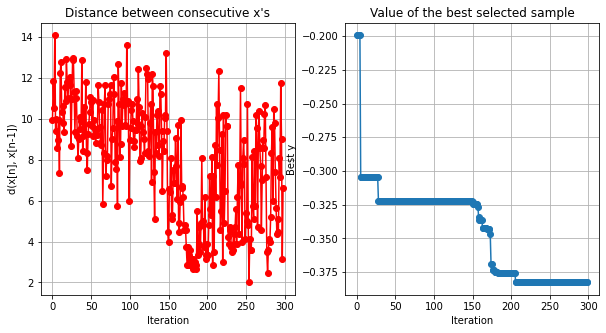

4終わり
[1, 1, 1, 2, 2, 2, 2, 3, 3, 2, 2, 3, 3, 1]
--------------------------------------------------------------------------------
速度:0.12107369599834783 ,精度:0.7623355263157895
速度評価値:0.2264689085374851 ,精度評価値:2.6045422617653946
評価指標:0.41670470922137415
--------------------------------------------------------------------------------
[1, 1, 1, 2, 2, 4, 3, 3, 4, 3, 4, 1, 5, 2]
--------------------------------------------------------------------------------
速度:0.12346108199926675 ,精度:0.7798108552631579
速度評価値:0.2243617073849132 ,精度評価値:2.664247248887848
評価指標:0.4138705312520616
--------------------------------------------------------------------------------
[1, 1, 2, 2, 1, 0, 2, 4, 2, 1, 2, 5, 1, 1]
--------------------------------------------------------------------------------
速度:0.11376274799840758 ,精度:0.7650082236842105
速度評価値:0.2329218399218267 ,精度評価値:2.6136736127370637
評価指標:0.4277261570590976
--------------------------------------------------------------------------------
[2, 1, 1, 1, 2, 3

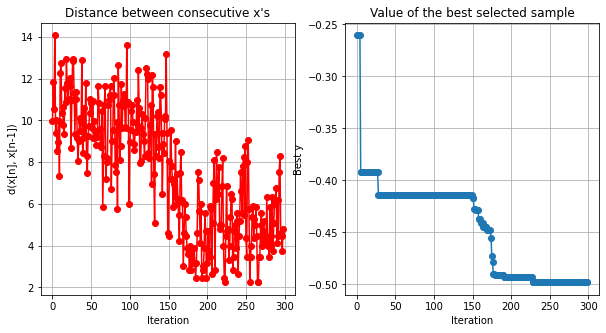

3終わり
[1, 1, 1, 2, 2, 2, 2, 3, 3, 2, 2, 3, 3, 1]
--------------------------------------------------------------------------------
速度:0.11748268800147343 ,精度:0.7623355263157895
速度評価値:0.3444577109847351 ,精度評価値:1.7363615078435963
評価指標:0.5748727280312113
--------------------------------------------------------------------------------
[1, 1, 1, 2, 2, 4, 3, 3, 4, 3, 4, 0, 5, 2]
--------------------------------------------------------------------------------
速度:0.11248591299954569 ,精度:0.7639802631578947
速度評価値:0.3510732373632629 ,精度評価値:1.7401077031140249
評価指標:0.5842681834634168
--------------------------------------------------------------------------------
[1, 1, 2, 2, 1, 0, 3, 3, 2, 2, 2, 5, 0, 1]
--------------------------------------------------------------------------------
速度:0.10575084899755893 ,精度:0.7442434210526315
速度評価値:0.3599901875059102 ,精度評価値:1.695153359868883
評価指標:0.5938646734920116
--------------------------------------------------------------------------------
[2, 1, 1, 1, 2, 2,

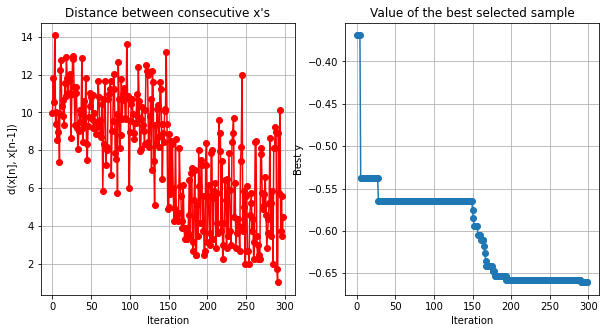

2終わり
[1, 1, 1, 2, 2, 2, 2, 3, 3, 2, 2, 3, 3, 1]
--------------------------------------------------------------------------------
速度:0.1161698029973195 ,精度:0.7623355263157895
速度評価値:0.6923918344049323 ,精度評価値:0.8681807539217982
評価指標:0.7703855229797446
--------------------------------------------------------------------------------
[1, 1, 1, 2, 3, 4, 3, 3, 4, 3, 3, 0, 5, 2]
--------------------------------------------------------------------------------
速度:0.11183964100200683 ,精度:0.786389802631579
速度評価値:0.7038577502775653 ,精度評価値:0.8955748068368065
評価指標:0.7882261317509798
--------------------------------------------------------------------------------
[1, 1, 2, 1, 2, 2, 4, 1, 3, 4, 3, 4, 0, 3]
--------------------------------------------------------------------------------
速度:0.10899366000376176 ,精度:0.7413651315789473
速度評価値:0.7113936758933537 ,精度評価値:0.8442987590728167
評価指標:0.7721690795289741
--------------------------------------------------------------------------------
[1, 1, 2, 2, 2, 0, 

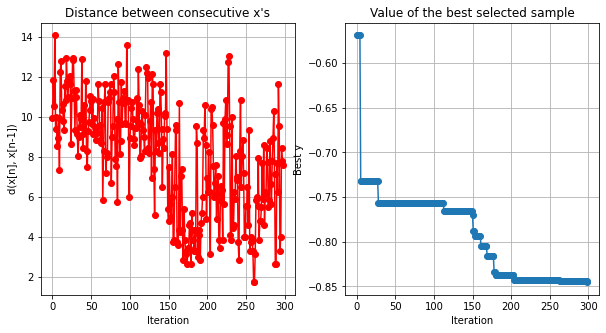

1終わり
[1, 1, 1, 2, 2, 2, 3, 3, 3, 2, 2, 3, 3, 1]
--------------------------------------------------------------------------------
速度:0.11266598099609837 ,精度:0.7537006578947368
速度評価値:1.4033393387095914 ,精度評価値:0.42917349566846175
評価指標:0.6573225991156265
--------------------------------------------------------------------------------
[1, 1, 2, 1, 3, 3, 3, 1, 4, 4, 4, 2, 1, 3]
--------------------------------------------------------------------------------
速度:0.11244675099442247 ,精度:0.7835115131578947
速度評価値:1.4045003450454716 ,精度評価値:0.4461484429875907
評価指標:0.6771848296332458
--------------------------------------------------------------------------------
[1, 2, 1, 2, 3, 4, 3, 3, 3, 2, 2, 0, 6, 2]
--------------------------------------------------------------------------------
速度:0.1111870969980373 ,精度:0.7859786184210527
速度評価値:1.4111712671804 ,精度評価値:0.44755326621400143
評価指標:0.6795781714470177
--------------------------------------------------------------------------------
[1, 1, 2, 1, 2, 1, 

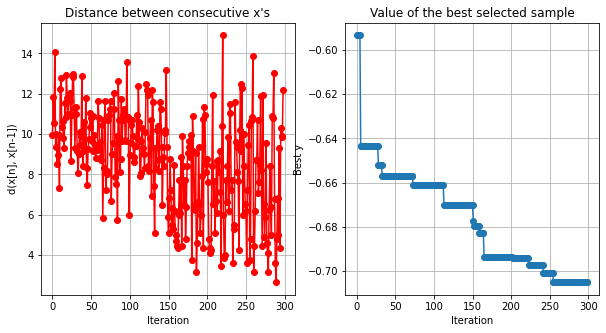

0.5終わり
[1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 2, 3, 3, 1]
--------------------------------------------------------------------------------
速度:0.11910727200302063 ,精度:0.7810444078947368
速度評価値:2.0538409680166025 ,精度評価値:0.2964957465074533
評価指標:0.5181854219070792
--------------------------------------------------------------------------------
[1, 2, 1, 3, 2, 3, 3, 3, 2, 2, 1, 1, 6, 2]
--------------------------------------------------------------------------------
速度:0.11380302299949108 ,精度:0.780016447368421
速度評価値:2.0959766245401705 ,精度評価値:0.29610551783345035
評価指標:0.51890378911523
--------------------------------------------------------------------------------
[1, 1, 2, 1, 3, 3, 3, 2, 4, 3, 4, 1, 3, 2]
--------------------------------------------------------------------------------
速度:0.11967049499799032 ,精度:0.78125
速度評価値:2.0493668623238976 ,精度評価値:0.29657379224225394
評価指標:0.5181618732528502
--------------------------------------------------------------------------------
[1, 2, 1, 1, 3, 3, 2, 4, 2,

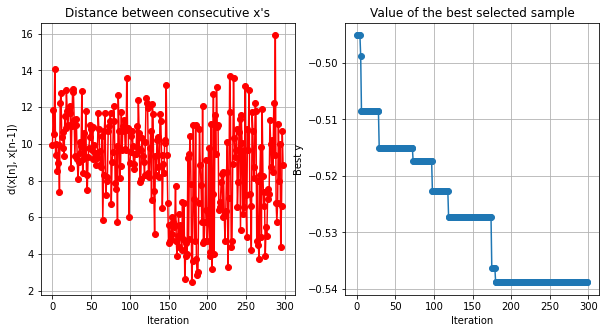

0.3333333333333333終わり


In [ ]:
def evaluater_memo(gane):
    set_seed(SEED)
    # 入力された乗数から、本当のモデルのノード数とする。
    gane=list(map(int,gane[0]))
    print(gane)
    temp = temp_list[gane[-1]]
    model_gane=[]
    gane_temp = gane[-1]
    gane = gane[:-1]
    gane_number=[0,16,32,64,128,256,512]
    for i in gane:
        if gane_number[i]!=0:
            model_gane.append(gane_number[i])

    net: torch.nn.Module = CreateVGG_2(model_gane)
    net.to(device)
    optimizer = torch.optim.SGD(params=net.parameters(), lr=0.01, momentum=0.9)
    # optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
    criterion = T_S_Closs_entropy()

    """　学習　開始"""
    loss = None
    net.train()
    for e in range(len(max_model_outputs_list)):
        data_one = max_model_outputs_list[e][0].to(device)
        output = net(data_one)

        optimizer.zero_grad()
        loss = criterion(output,max_model_outputs_list[e][1].to(device),max_model_outputs_list[e][2].to(device),temp)

        loss.backward()
        optimizer.step()

    """  学習したモデルの速度と精度の評価をする。(推論)"""
    net.eval()
    correct = 0
    t1 = time.perf_counter()
    with torch.no_grad():
        for images, labels in loader['test']:
            images = images.to(device) 
            labels = labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            #torch.max(a, axis) (axis=0:col, axis=1:row)ごとに最大値を取ってくれている。
            correct += (predicted == labels).sum().item()

    acc = float(correct / (38*128))
    t2 = time.perf_counter()
    elapsed_time = t2-t1


    global initial_X
    global initial_Y

    initial_X.append(gane+[gane_temp]+[0])
    initial_Y.append([elapsed_time,acc])

    # accとelapsedは、教師モデルの出力を受け取るようにしておきましょう。
    return speed_acc_normalization_harmonic_mean(s_max,0,elapsed_time,a_max,0,acc)



# NNモデルの最大の層
VGG_max_sou = 13
# NNモデルの最大のノード数7→0~6
VGG_max_nodel = 7

bounds = []
for i in range(VGG_max_sou):
    bounds.append({'name': 'x_'+str(i), 'type': 'discrete', 'domain': (range(VGG_max_nodel))})
bounds.append({'name': '温度', 'type': 'discrete', 'domain': range(len(temp_list))})

myBopt = GPyOpt.methods.BayesianOptimization(evaluater_memo
                                             , domain=bounds
                                             , normalize_Y=False
                                             , maximize=True
                                             , initial_design_numdata = initial_epoch
                                             , acquisition_type='EI')

# init_X_np = np.array(initial_X).reshape((len(initial_X) , 14))
# init_Y_np = np.array([-speed_acc_normalization_harmonic_mean_init(s_max,0,i[0],a_max,0,i[1]) for i in initial_Y]).reshape((len(initial_Y) , 1))
#　init_Y_np(初期値のYの値)は、最大値を見つけ出す場合はマイナスをつけて置きましょう。

# --------------------- 上記でメモ化される ------------------------

np_initial_X_write = np.array(initial_X)
np.savetxt('/content/gdrive/My Drive/2020_秋_TERM/2020_12_終月/initial/V100_np_save_X.txt', np_initial_X_write, fmt = '%s')
np_initial_Y_write = np.array(initial_Y)
np.savetxt('/content/gdrive/My Drive/2020_秋_TERM/2020_12_終月/initial/V100_np_save_Y.txt', np_initial_Y_write, fmt = "%s")

X =[] 
y =[]
memo = []
for rt_i in range(len(ratio)):
    xx, yy = evaluated_final(rt_i,initial_X,initial_Y)
    memo.append(xx)
    X.append(rt_i)
    y.append(-yy)
    print(str(ratio[rt_i])+"終わり")

    # ratio[rt_i]として、evaluated_finalに渡してしまうと、boundsが整数取るから保存できなくなる。

In [ ]:
# with open('/content/gdrive/My Drive/2020_秋_TERM/2020_12_終月/initial/np_save_X.txt') as file_read_:
#     print(file_read_.read())
# with open('/content/gdrive/My Drive/2020_秋_TERM/2020_12_終月/initial/np_save_Y.txt') as file_read_:
#     dddd = file_read_.read()
#     # dddd += 1
#     print(*map(float,(dddd.split())))

In [18]:
for i in range(len(memo)):
  print(list(memo[i]))
  print(sum(memo[i]))

[0, 0, 0, 2, 2, 0, 0, 2, 0, 1, 0, 5, 0, 4, 0]
16
[0, 0, 0, 1, 0, 0, 0, 0, 2, 2, 0, 0, 3, 2, 1]
11
[0, 1, 0, 2, 0, 0, 0, 2, 0, 1, 0, 3, 0, 1, 2]
12
[0, 0, 1, 1, 0, 2, 0, 0, 2, 4, 2, 0, 5, 4, 3]
24
[0, 2, 2, 3, 0, 0, 1, 0, 0, 0, 0, 3, 6, 0, 4]
21
[2, 1, 3, 2, 4, 4, 2, 0, 5, 4, 4, 0, 3, 4, 5]
43


# **得られたモデル群から(フィルター数),aとtを出力する。**

In [25]:
def evaluater_a_t(gane):
    set_seed(SEED)
    # 入力された乗数から、本当のモデルのノード数とする。
    gane = list(map(int,gane))
    temp = temp_list[gane[-1]]
    gane = gane[:-1]
    model_gane=[]
    gane_number=[0,16,32,64,128,256,512]
    for i in gane:
        if gane_number[i]!=0:
            model_gane.append(gane_number[i])

    net: torch.nn.Module = CreateVGG_2(model_gane)
    net.to(device)
    optimizer = torch.optim.SGD(params=net.parameters(), lr=0.01, momentum=0.9)
    criterion = T_S_Closs_entropy()

    """　学習　開始"""
    loss = None
    net.train()
    for e in range(len(max_model_outputs_list)):
        data_one = max_model_outputs_list[e][0].to(device)
        output = net(data_one)

        optimizer.zero_grad()
        loss = criterion(output,max_model_outputs_list[e][1].to(device),max_model_outputs_list[e][2].to(device),temp)

        loss.backward()
        optimizer.step()

        if e % 782 == 0:
            print("実行割合 : {}/5 ,epoch : {} ,loss : {}".format(1+e//(782),(1+e//(782))*2,loss.item()))

    LOSS = loss.item()
    """  学習したモデルの速度と精度の評価をする。(推論)"""
    net.eval()
    correct = 0
    t1 = time.perf_counter()
    with torch.no_grad():
        for images, labels in loader['test']:
        # for images, labels in loader['test_final']:
            images = images.to(device) 
            labels = labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()

    # acc = float(correct / (10000-38*128))
    acc = float(correct / (38*128))
    t2 = time.perf_counter()
    elapsed_time = t2-t1

    # accとelapsedは、教師モデルの出力を受け取るようにしておきましょう。
    
    return (acc,elapsed_time,LOSS)

In [26]:
# evaluater_a_t(gane) 引数:ganeは普通の[0,1,2,3]のようなもの
t0_n=[]
a0_n=[]
l0_n=[]

for rt_i in range(len(memo)):
    aa,tt,LOSS = evaluater_a_t(memo[rt_i][:-1])
    t0_n.append(tt)
    a0_n.append(aa)
    l0_n.append(LOSS)

実行割合 : 1/5 ,epoch : 2 ,loss : 5.862022399902344
実行割合 : 2/5 ,epoch : 4 ,loss : 3.4170122146606445
実行割合 : 3/5 ,epoch : 6 ,loss : 2.7836852073669434
実行割合 : 4/5 ,epoch : 8 ,loss : 2.655277729034424
実行割合 : 5/5 ,epoch : 10 ,loss : 2.251929521560669
実行割合 : 1/5 ,epoch : 2 ,loss : 2.332489013671875
実行割合 : 2/5 ,epoch : 4 ,loss : 1.2507679462432861
実行割合 : 3/5 ,epoch : 6 ,loss : 0.7850185036659241
実行割合 : 4/5 ,epoch : 8 ,loss : 0.7402570247650146
実行割合 : 5/5 ,epoch : 10 ,loss : 0.6132439970970154
実行割合 : 1/5 ,epoch : 2 ,loss : 2.1234943866729736
実行割合 : 2/5 ,epoch : 4 ,loss : 1.0929505825042725
実行割合 : 3/5 ,epoch : 6 ,loss : 0.7366106510162354
実行割合 : 4/5 ,epoch : 8 ,loss : 0.6420144438743591
実行割合 : 5/5 ,epoch : 10 ,loss : 0.5304047465324402
実行割合 : 1/5 ,epoch : 2 ,loss : 5.8125505447387695
実行割合 : 2/5 ,epoch : 4 ,loss : 2.8295514583587646
実行割合 : 3/5 ,epoch : 6 ,loss : 2.6390724182128906
実行割合 : 4/5 ,epoch : 8 ,loss : 2.189695358276367
実行割合 : 5/5 ,epoch : 10 ,loss : 1.9894628524780273
実行割合 : 1/5 ,epoch : 2

In [27]:
for i in range(len(t0_n)):
    print(round(i,2))
    print(t0_n[i])
    print(a0_n[i])
    print(speed_acc_normalization_harmonic_mean(s_max,0,t0_n[i],a_max,0,a0_n[i]))
    # print(speed_acc_normalization(s_max,0,t0_n[i],a_max,0,a0_n[i]))

y_fin = np.atleast_2d(t0_n).T
X_fin = np.atleast_2d(a0_n).T
# X_fin = np.atleast_2d([ num/10 for num in range(1,10)]).T


0
0.0669238210102776
0.7689144736842105
--------------------------------------------------------------------------------
速度:0.0669238210102776 ,精度:0.7689144736842105
速度評価値:0.8227911790806846 ,精度評価値:0.8756731444626551
評価指標:0.8484089174373921
--------------------------------------------------------------------------------
0.8484089174373921
1
0.058778004997293465
0.7247121710526315
--------------------------------------------------------------------------------
速度:0.058778004997293465 ,精度:0.7247121710526315
速度評価値:0.8443606356552713 ,精度評価値:0.8253336455162725
評価指標:0.8347387296156226
--------------------------------------------------------------------------------
0.8347387296156226
2
0.06357732700416818
0.7454769736842105
--------------------------------------------------------------------------------
速度:0.06357732700416818 ,精度:0.7454769736842105
速度評価値:0.8316524223283637 ,精度評価値:0.8489815031608523
評価指標:0.8402276223362227
-----------------------------------------------------------------------

Text(0, 0.5, 'time')

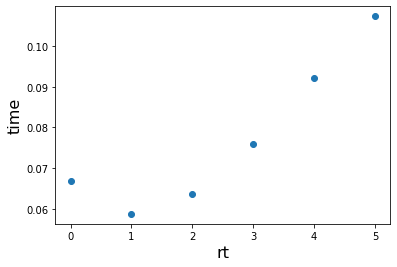

In [28]:
plt.scatter(np.atleast_2d([num for num in range(len(ratio))]).T,np.atleast_2d(t0_n).T)
plt.xlabel('rt', fontsize=16)
plt.ylabel('time', fontsize=16)

Text(0, 0.5, 'accuracy')

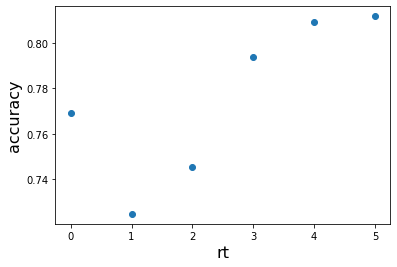

In [29]:
plt.scatter(np.atleast_2d([num for num in range(len(ratio))]).T,np.atleast_2d(a0_n).T)
plt.xlabel('rt', fontsize=16)
plt.ylabel('accuracy', fontsize=16)

Text(0, 0.5, 'Loss')

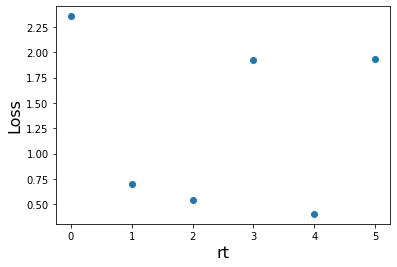

In [30]:
plt.scatter(np.atleast_2d([num for num in range(len(ratio))]).T,np.atleast_2d(l0_n).T)
plt.xlabel('rt', fontsize=16)
plt.ylabel('Loss', fontsize=16)

Text(0, 0.5, 'time')

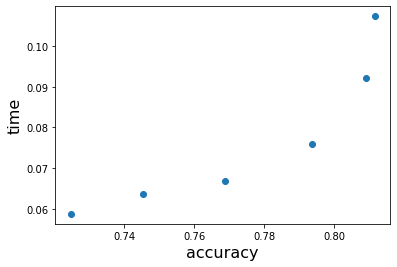

In [31]:
plt.scatter(np.atleast_2d(a0_n).T,np.atleast_2d(t0_n).T)
plt.xlabel('accuracy', fontsize=16)
plt.ylabel('time', fontsize=16)

Text(0, 0.5, 'time')

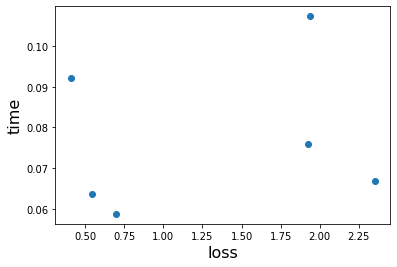

In [32]:
plt.scatter(np.atleast_2d(l0_n).T,np.atleast_2d(t0_n).T)
plt.xlabel('loss', fontsize=16)
plt.ylabel('time', fontsize=16)

In [ ]:
memo2 = [
         [0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0],
         [0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 2, 0, 2, 3, 0, 0, 0, 0, 0, 1],
         [1, 3, 2, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 1],
         [2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 3, 2],
         [1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 4, 0, 3],
         [0, 2, 0, 0, 0, 1, 0, 0, 4, 3, 0, 0, 0, 2],
         [2, 0, 0, 0, 0, 1, 3, 0, 0, 0, 1, 5, 0, 4],
         [1, 0, 0, 0, 0, 2, 2, 3, 0, 2, 0, 0, 0, 5],
         [2, 2, 0, 0, 0, 1, 1, 0, 4, 5, 0, 0, 0, 3],
         [0, 2, 2, 0, 0, 3, 0, 0, 3, 3, 5, 5, 4, 4],
         [0, 3, 2, 3, 0, 2, 4, 0, 0, 3, 0, 4, 6, 5],
         [2, 0, 2, 3, 0, 4, 4, 0, 6, 3, 3, 0, 0, 6]]

In [ ]:
# evaluater_a_t(gane) 引数:ganeは普通の[0,1,2,3]のようなもの
t0_n2=[]
a0_n2=[]
l0_n2=[]

for rt_i in range(len(memo2)):
    aa,tt,LOSS = evaluater_a_t(memo2[rt_i][:-1])
    t0_n2.append(tt)
    a0_n2.append(aa)
    l0_n2.append(LOSS)

In [ ]:
for i in range(len(t0_n2)):
    print(t0_n2[i])
    print(l0_n2[i])
    print(a0_n2[i])
    print(speed_acc_normalization_harmonic_mean(s_max,0,t0_n2[i],a_max,0,a0_n2[i]))
    print(speed_acc_normalization(s_max,0,t0_n2[i],a_max,0,a0_n2[i]))


In [ ]:
ratio=[4,3.8,3.4,3,2.8,2.4,2,1.8,1.4,1,1/2,1/3,1/4]

In [ ]:
plt.scatter(np.atleast_2d([ratio[num] for num in range(0,len(memo2))]).T,np.atleast_2d(t0_n2).T)
plt.xlabel('rt', fontsize=16)
plt.ylabel('time', fontsize=16)

In [ ]:
plt.scatter(np.atleast_2d([ratio[num] for num in range(0,len(memo2))]).T,np.atleast_2d(a0_n2).T)
plt.xlabel('rt', fontsize=16)
plt.ylabel('accuracy', fontsize=16)

In [ ]:
plt.scatter(np.atleast_2d([ratio[num] for num in range(0,len(memo2))]).T,np.atleast_2d(l0_n2).T)
plt.xlabel('rt', fontsize=16)
plt.ylabel('Loss', fontsize=16)

In [ ]:
plt.scatter(np.atleast_2d(a0_n2).T,np.atleast_2d(t0_n2).T)
plt.xlabel('accuracy', fontsize=16)
plt.ylabel('time', fontsize=16)

In [ ]:
plt.scatter(np.atleast_2d(l0_n2).T,np.atleast_2d(t0_n2).T)
plt.xlabel('loss', fontsize=16)
plt.ylabel('time', fontsize=16)

# **ガウス過程部分**

In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF, WhiteKernel
from sklearn.preprocessing import StandardScaler

In [ ]:
y_fin = np.atleast_2d(t0_n2).T*100
X_fin = np.atleast_2d(l0_n2).T

In [ ]:
plot_X = np.atleast_2d(np.linspace(50, 130, 1000)).T
scaler_y = StandardScaler().fit(y_fin)

kernel = ConstantKernel() * RBF() + WhiteKernel()
gpr = GaussianProcessRegressor(kernel=kernel, alpha=0)
gpr.fit(X_fin, scaler_y.transform(y_fin))

print(gpr.kernel_)

0.905**2 * RBF(length_scale=6.52) + WhiteKernel(noise_level=0.199)


In [ ]:
# plot_Xに対する平均および標準偏差の予測
pred_mu, pred_sigma = gpr.predict(plot_X, return_std=True)
pred_mu = scaler_y.inverse_transform(pred_mu)
pred_sigma = pred_sigma.reshape(-1, 1) * scaler_y.scale_

# 各xに対する95%信頼区間を表示
fig = plt.figure(figsize=(8, 4))
plt.plot(X_fin, y_fin, 'r.', markersize=16)
plt.plot(plot_X, pred_mu, 'b')
# データが正規分布に従う場合、95%信頼区間は平均から標準偏差の1.96倍以内の区間となる
plt.fill_between(plot_X.squeeze(), (pred_mu - 1.9600 * pred_sigma).squeeze(), (pred_mu + 1.9600 * pred_sigma).squeeze())
plt.xlabel('loss', fontsize=16)
plt.ylabel('time', fontsize=16)
# plt.xlim(0,100)
# plt.ylim(0,400)
plt.show()

In [ ]:
plt.plot(pred_sigma)

In [ ]:
y_fin = np.atleast_2d(t0_n2).T*100
X_fin = np.atleast_2d(a0_n2).T*100

In [ ]:
plot_X = np.atleast_2d(np.linspace(50, 86, 10)).T
scaler_y = StandardScaler().fit(y_fin)

kernel = ConstantKernel() * RBF() + WhiteKernel()
gpr = GaussianProcessRegressor(kernel=kernel, alpha=0)
gpr.fit(X_fin, scaler_y.transform(y_fin))

print(gpr.kernel_)

0.852**2 * RBF(length_scale=1.31) + WhiteKernel(noise_level=0.155)


In [ ]:
# plot_Xに対する平均および標準偏差の予測
pred_mu, pred_sigma = gpr.predict(plot_X, return_std=True)
pred_mu = scaler_y.inverse_transform(pred_mu)
pred_sigma = pred_sigma.reshape(-1, 1) * scaler_y.scale_

# 各xに対する95%信頼区間を表示
fig = plt.figure(figsize=(8, 4))
plt.plot(X_fin, y_fin, 'r.', markersize=16)
plt.plot(plot_X, pred_mu, 'b')
# データが正規分布に従う場合、95%信頼区間は平均から標準偏差の1.96倍以内の区間となる
plt.fill_between(plot_X.squeeze(), (pred_mu - 1.9600 * pred_sigma).squeeze(), (pred_mu + 1.9600 * pred_sigma).squeeze())
plt.xlabel('accu', fontsize=16)
plt.ylabel('time', fontsize=16)
# plt.xlim(0,100)
# plt.ylim(0,400)
plt.show()

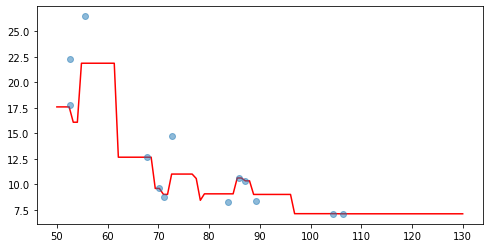

In [ ]:
from sklearn.ensemble import RandomForestRegressor # ランダムフォレスト回帰用
from sklearn.linear_model import LogisticRegression


plot_X = np.atleast_2d(np.linspace(50, 130, 100)).T
# ランダムフォレスト実行
rfr = RandomForestRegressor(3)  # インスタンスの生成　木の数を100個に指定
rfr.fit(X_fin, y_fin)            # 学習実行
yfit = rfr.predict(plot_X) # 予測実行

# 結果比較用に実際の値を取得。
ytrue = y_fin # xfitを波発生関数に食わせて、その結果を取得

# 結果確認
plt.figure(figsize = (8,4))
plt.plot(plot_X, yfit, '-r')                # 予測値のplot
plt.plot(X_fin, ytrue, 'o', alpha = 0.5)  # 正解値のplot

In [ ]:
y_fin = np.atleast_2d(t0_n2).T*100
X_fin = np.atleast_2d(l0_n2).T